# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
### Organized by Manuel Alejandro Sanchez
***
Objectives of this project is to detect lane lines from collected road images using Python and OpenCV. Ideally images are collected from fixed position with centered front view in a vehicle.

Lane lines are not always the same color, and even lines of the same color under different lighting conditions (day, night, etc) may fail to be detected by our simple color selection. What we need is to take our algorithm to the next level to detect lines of any color using sophisticated computer vision methods. 
  
The following techniques will be used to build pipeline to detect line lanes within images, which will then be applied to detect line lanes within a video file:

    Color Selection
    Canny Edge Detection
    Region of Interest Selection
    Hough Transform Line Detection

---

## Import Packages

The following libraries should be condidered when running this program:


In [3]:
#Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# turns on inline plotting.
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


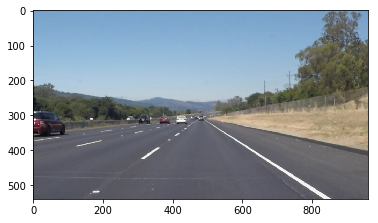

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Test Images

Let's load and examine the test images.

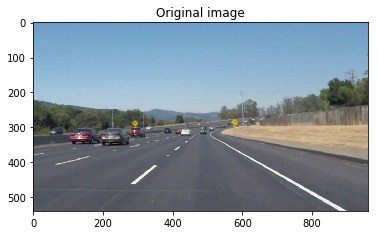

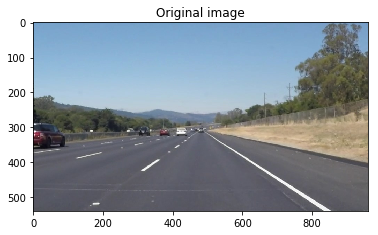

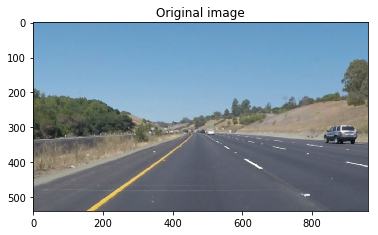

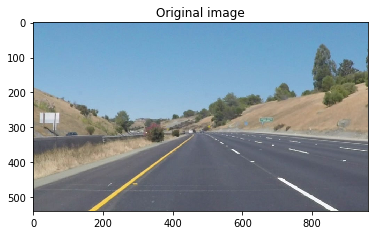

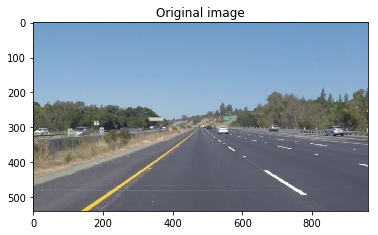

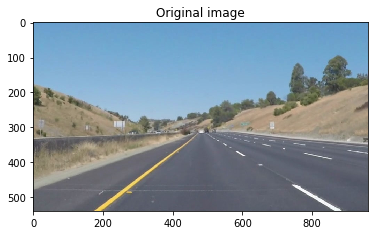

In [5]:
os.listdir("test_images/")
in_dir = 'test_images/'
out_dir = 'test_images_output/'
file_names = os.listdir(in_dir)
#file_name = ['solidYellowCurve.jpg']

for file_name in file_names:
    image = mpimg.imread(in_dir + file_name)  
    plt.title('Original image')
    plt.imshow(image)
    plt.show()


In [6]:
## Build a Lane Finding Pipeline


## Color Selection

### RGB Color Space

The images are loaded in RGB color space.  Let's try selecting only yellow and white colors in the images using the RGB channels.

Reference: [RGB Color Code Chart](http://www.rapidtables.com/web/color/RGB_Color.htm)

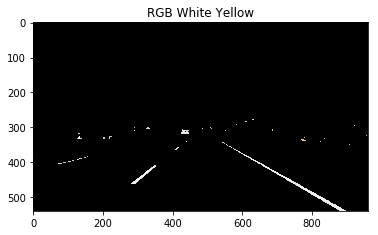

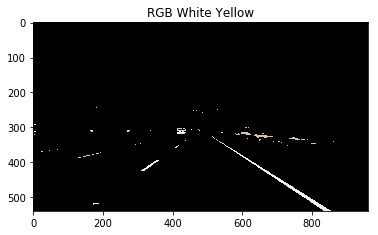

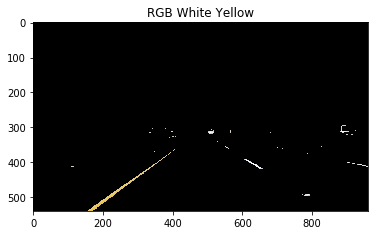

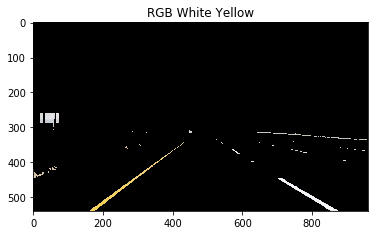

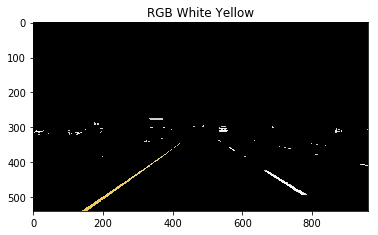

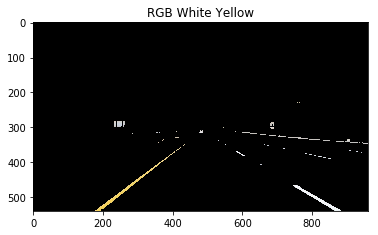

In [7]:
# image is expected be in RGB color space
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name) 
    RGBWhiteYellow = select_rgb_white_yellow(image)
    plt.title('RGB White Yellow')
    plt.imshow(RGBWhiteYellow)
    plt.show()
    #plt.imsave(out_dir + file_name, select_rgb_white_yellow)


It looks pretty good, however to improve selection of only white yellow we could define a more suitable color space.

### Color Space

Using `cv2.cvtColor`, we can convert RGB image into different color space.  For example, [HSL and HSV color space](https://en.wikipedia.org/wiki/HSL_and_HSV). 

## HSV Color Space

To improve our accuracy we want to separate color components from intensity for various reasons, such as robustness to lighting changes, or removing shadows. HSV is one of many color spaces that separate color from intensity very well. 

How does it look when RGB images are converted into HSV color space?

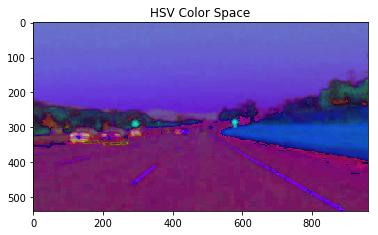

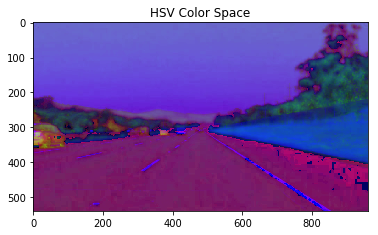

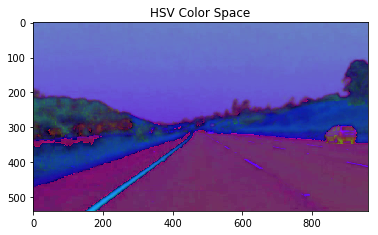

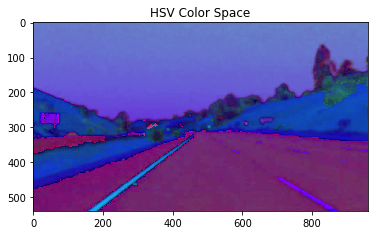

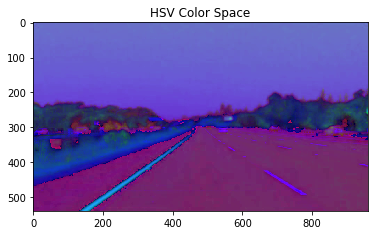

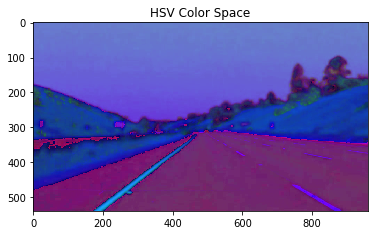

In [8]:
def hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name)   
    HSV_img = hsv(image)
    plt.title('HSV Color Space')
    plt.imshow(HSV_img)
    plt.show()

Let's build a filter to select those white and yellow lines from converted HSV images.

- Use `cv2.inRange` to filter the white color and the yellow color seperately.  
  The function returns 255 when the filter conditon is satisfied.  Otherwise, it returns 0.
- Use `cv2.bitwise_or` to combine these two binary masks.  
  The combined mask returns 255 when either white or yellow color is detected.
- Use `cv2.bitwise_and` to apply the combined mask onto the original RGB image

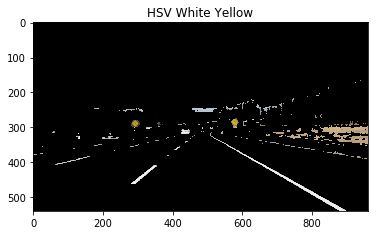

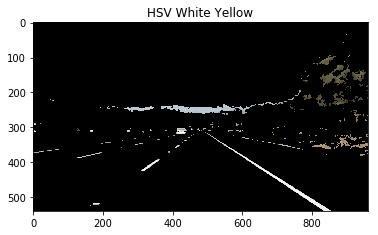

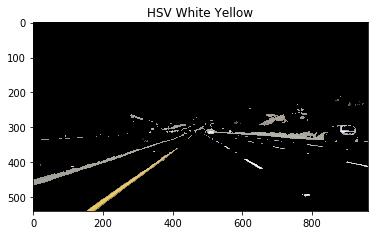

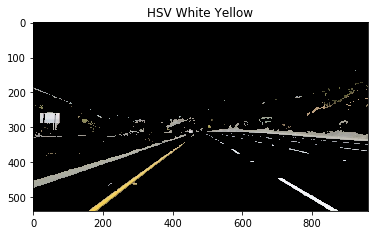

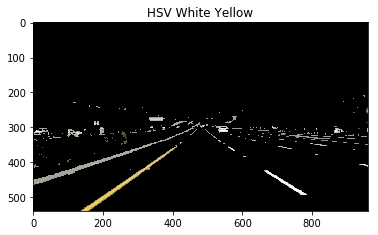

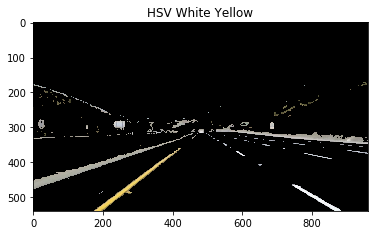

In [9]:
def select_white_yellow(img):
    """Returns a mask that only keeps white and yellow color"""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([15, 80 ,40])
    upper_yellow = np.array([30, 255, 255])

    lower_white = np.array([0, 0, 150])
    upper_white = np.array([180, 30, 255])
    
    white = cv2.inRange(hsv, lower_white, upper_white)
    yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = cv2.bitwise_or(yellow, white)
    return cv2.bitwise_and(image, image, mask = mask)

for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name)   
    SelectWY = select_white_yellow(image)
    plt.title('HSV White Yellow')
    plt.imshow(SelectWY)
    plt.show()

The combined HSV filters selection of yellow and white lines better than just RGB. 

## Canny Edge Detection

We can now use canny edge detection to define smooth straight lines

In order to acheive canny edge detection correctly within OpenCV we should refer to the following steps:

- 1st use `cv2.cvtColor` to convert images into gray scale
- 2nd use `cv2.GaussianBlur` to smooth out rough edges 
- 3rd use `cv2.Canny` to find edges

Note: [Canny Edge Detection Wikipedia](https://en.wikipedia.org/wiki/Canny_edge_detector) has a good description in good details.

Let's take a look at each step in details.

### Gray Scaling

The images should be converted into gray scaled ones in order to detect shapes (edges) in the images.  This is because the Canny edge detection measures the magnitude of pixel intensity changes or gradients (more on this later).

Lets convert our previous white and yellow line images into gray scale for edge detection.

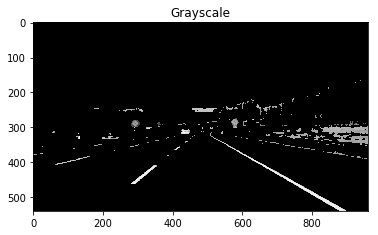

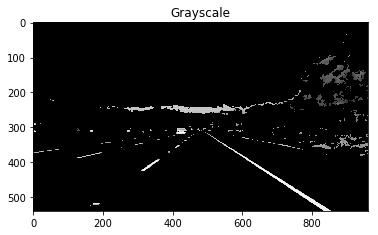

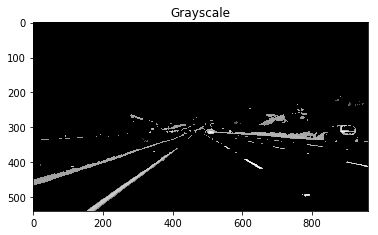

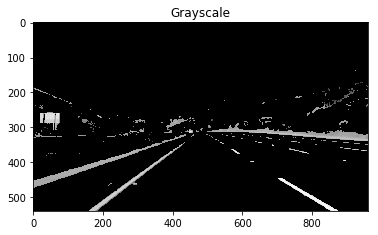

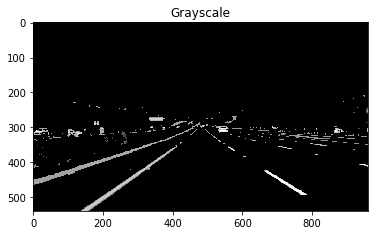

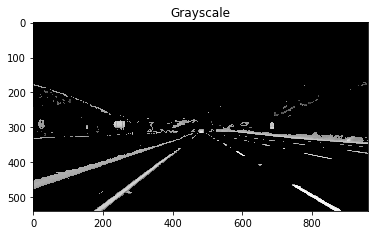

In [10]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name)  
    wy = select_white_yellow(image)
    gray = grayscale(wy)
    plt.title('Grayscale')
    plt.imshow(gray, cmap='gray')
    plt.show()    


### Gaussian Smoothing (Gaussian Blur)

As you can see,  the above images have many rough edges which causes many noisy edges to be detected. GaussianBlur is essentially the way of suppressing noise and spurious gradients by averaging.

- [Gaussian Filter OpenCV Theory](http://docs.opencv.org/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html#gaussian-filter)

The GaussianBlur takes a kernel_size parameter which you'll need to play with to find one that works best. I tried 3, 5, 9, 11, 15, 17 (they must be positive and odd) and check the edge detection (see the next section) result. The bigger the kernel_size value is, the more blurry the image becomes.

The bigger kearnel_size value requires more time to process. It is not noticeable with the test images but we should keep that in mind (later we'll be processing video clips). So, we should prefer smaller values if the effect is similar.

Lets convert our previous white and yellow line selection in grayscale with Gaussian Blur.

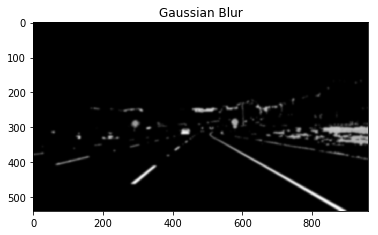

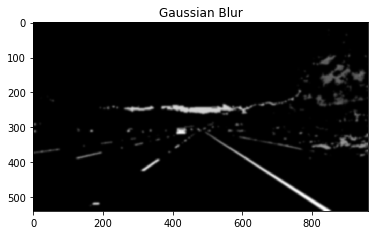

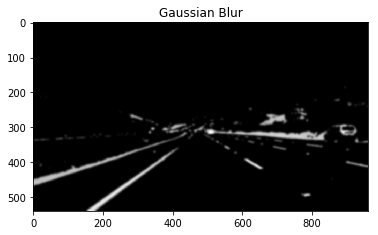

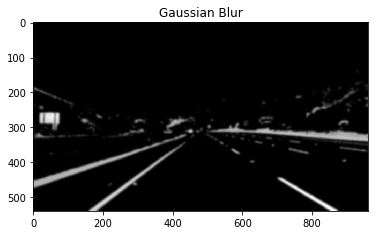

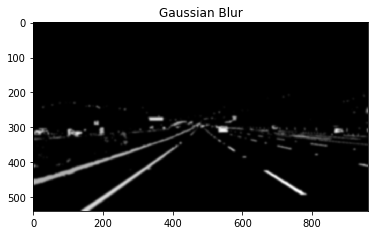

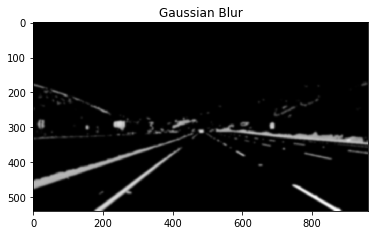

In [11]:
def gaussian_blur(img, kernel_size=15):
    """Applies a Gaussian Noise kernel"""
    # Define a kernel size for Gaussian smoothing / blurring, should be odd number
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name)  
    wy = select_white_yellow(image)
    gray = grayscale(wy)
    smooth = gaussian_blur(gray)
    plt.title('Gaussian Blur')
    plt.imshow(smooth, cmap='gray')
    plt.show()    

The GaussianBlur takes a kernel_size parameter which you'll need to play with to find one that works best. I tried 3, 5, 9, 11, 15, 17 (they must be positive and odd) and check the edge detection (see the next section) result. The bigger the kernel_size value is, the more blurry the image becomes.

The bigger kearnel_size value requires more time to process. It is not noticeable with the test images but we should keep that in mind (later we'll be processing video clips). So, we should prefer smaller values if the effect is similar.

### Edge Detection

Now we are ready for edge detection. 

`cv2.Canny` takes two threshold values which requires some explanation.

According to the OpenCV documentation, the double thresholds are used as follows:

- If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
- If a pixel gradient value is below the lower threshold, then it is rejected.
- If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
- Canny recommended a upper:lower ratio between 2:1 and 3:1.

These two threshold values are empirically determined.  Basically, you will need to define them through trial and error.

I first set the `low_threshold` to zero and then adjust the `high_threshold`.   If `high_threshold` is too high, you find no edges.  If `high_threshold` is too low, you find too many edges.  Once you find a good `high_threshold`, adjust the `low_threshold` to discard the weak edges (noises) connected to the strong edges.

- [Canny Edge Detection OpenCV Theory](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)

Lets apply edge detection from our previous smoothed white and yellow line selection.

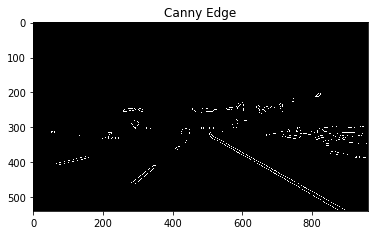

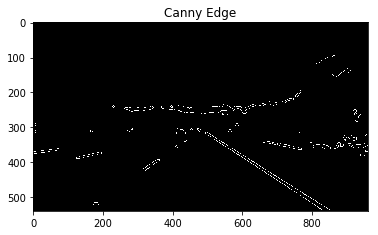

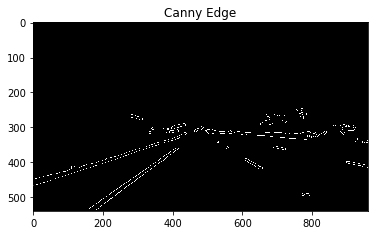

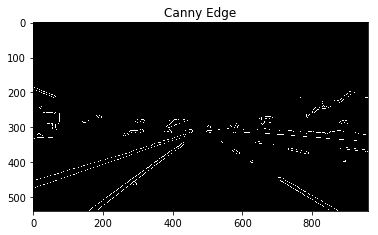

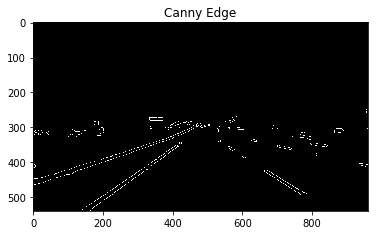

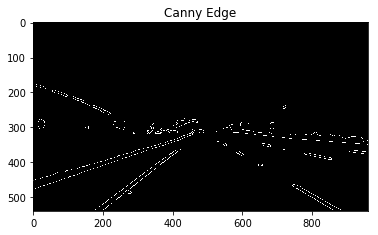

In [12]:
def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name)   
    wy = select_white_yellow(image)
    gray = grayscale(wy)
    smooth = gaussian_blur(gray)
    edged = canny(smooth)
    plt.title('Canny Edge')
    plt.imshow(edged, cmap='gray')
    plt.show() 

## Region of Interest Selection

Assuming that the front facing camera that has taken these images is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image, we can take advantage by adding a criterion to only consider pixels for color selection in the region where we expect to find the lane lines.

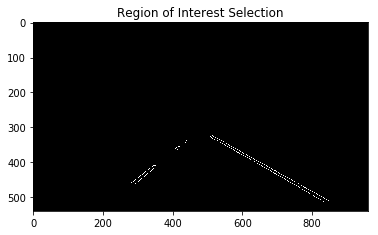

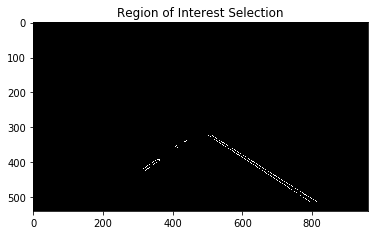

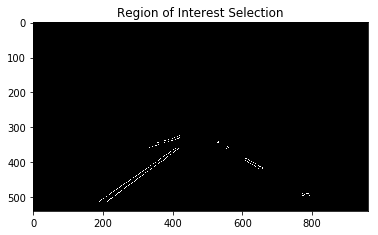

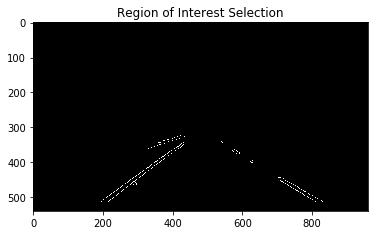

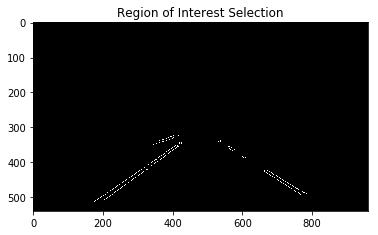

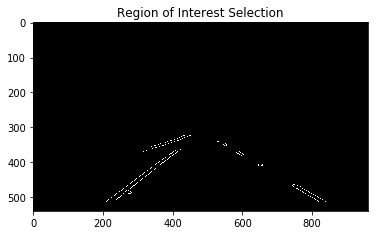

In [13]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def region_of_interest(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name)   
    wy = select_white_yellow(image)
    gray = grayscale(wy)
    smooth = gaussian_blur(gray)
    edged = canny(smooth)
    roi = region_of_interest(edged)
    plt.title('Region of Interest Selection')
    plt.imshow(roi, cmap='gray')
    plt.show() 

Now we have lane lines in our region of interest but we need to recognize them as lines.  Especially, two lines: the left lane and the right lane.

## Hough Transform Line Detection

Hough Transform has been referenced as an ideal function to process detection using hough space. To accomplish the task of finding lane lines, we need to specify some parameters to say what kind of lines we want to detect (i.e., long lines, short lines, bendy lines, dashed lines, etc.). 

To do this, we'll be using an OpenCV function called `cv2.HoughLinesP` that takes several parameters:

- rho – Distance resolution of the accumulator in pixels.
- theta – Angle resolution of the accumulator in radians.
- threshold – Accumulator threshold parameter. Only those lines are returned that get enough votes (> `threshold`).
- minLineLength – Minimum line length. Line segments shorter than that are rejected.
- maxLineGap – Maximum allowed gap between points on the same line to link them.

More details can be found:

- [Hough Line Transform OpenCV Theory](http://docs.opencv.org/doc/tutorials/imgproc/imgtrans/hough_lines/hough_lines.html)

Let's find and draw the lines onto the original images using hough transform.  

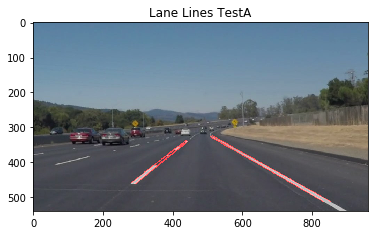

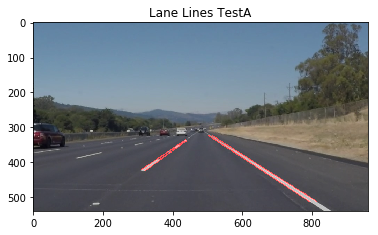

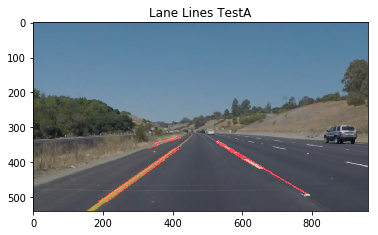

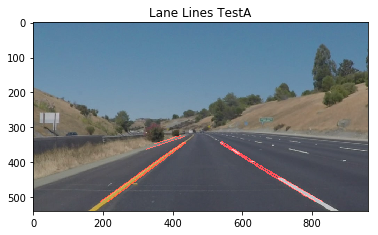

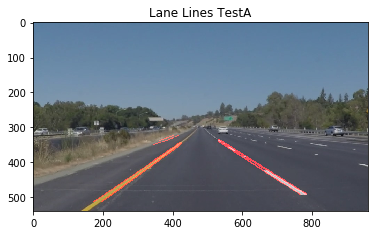

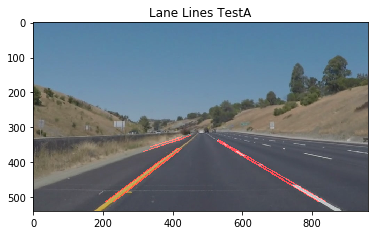

In [14]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                       
def hough_lines_test(img):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
            
for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name)   
    wy = select_white_yellow(image)
    gray = grayscale(wy)
    smooth = gaussian_blur(gray)
    edged = canny(smooth)
    roi = region_of_interest(edged)
    lines = hough_lines_test(roi)
    annotated_img = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    plt.title('Lane Lines TestA')
    plt.imshow(annotated_img, cmap='gray')
    plt.show()
    


### Averaging and Extrapolating Lines

As demonstrated, hough transform was able to find multiple linesand only some lane lines are only partially recognize, however we want to customize this search to meet our lane line specification better by extrapolating the line to cover full lane line length.

We want two lane lines: one for the left and the other for the right.  The left lane should have a positive slope, and the right lane should have a negative slope.  Therefore, we'll collect positive slope lines and negative slope lines separately and take averages.

Note: in the image, `y` coordinate is reversed.  The higher `y` value is actually lower in the image.  Therefore, the slope is negative for the left lane, and the slope is positive for the right lane.

In [15]:
def line_filter(line):
    """Filter out the line segments that don't meet the requirement."""
    for x1, y1, x2, y2 in line:
        if (x2-x1) == 0:
            # filter vertical line
            return True
        if math.fabs((y1 - y2)/(x1-x2)) > 1.8:
            # filter horizontal line
            return True
        if math.fabs((y1 - y2)/(x1-x2)) < 0.5:
            # filter horizontal line
            return True
        return False

def draw_lines_avg(img, lines, color=[0, 0, 255], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """             
    left_lane_max, right_lane_max = 0, 0
    left_slope, right_slope = -0.1, 0.1
    left_lane, right_lane = (0,0,0,0), (0,0,0,0)    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (line_filter(line)):
                continue
            slope = ((y2-y1)/(x2-x1))
            lane_length = math.hypot(x2-x1, y2-y1)

            #For left lane
            if(slope < -0.5):
                if(lane_length > left_lane_max):
                    left_lane = (x1,y1,x2,y2)
                    left_slope = slope
                    left_lane_max = lane_length
                   
            #For right lane
            elif(slope > 0.5):
                if(lane_length > right_lane_max):
                    right_lane = (x1,y1,x2,y2)
                    right_slope = slope
                    right_lane_max = lane_length
                    
    #Intercept: c = y - mx
    left_lane_intercept = left_lane[1] - (left_slope * left_lane[0])
    right_lane_intercept = right_lane[1] - (right_slope * right_lane[0])

    #Variables for a complete extrapolated line
    Y1 = 320 # top of the image
    Y2 = 550 # bottom of the image
    
    #Equation for extrapolated line
    #x = (y - c) / m
    LX1 = int((Y1 - left_lane_intercept)/left_slope)
    LX2 = int((Y2 - left_lane_intercept)/left_slope)
    RX1 = int((Y1 - right_lane_intercept)/right_slope)
    RX2 = int((Y2 - right_lane_intercept)/right_slope)

    #Adding Left Lane Line
    cv2.line(img, (LX1,Y1), (LX2,Y2), color, thickness)

    #Adding Right Lane Line
    cv2.line(img, (RX1,Y1), (RX2,Y2), color, thickness)

Using the above function, we can calculate average slope and intercept for the left and right lanes of each image.  

At this point we are able to build our Let's draw the lanes.

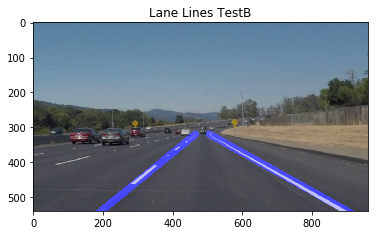

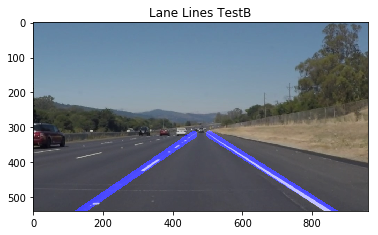

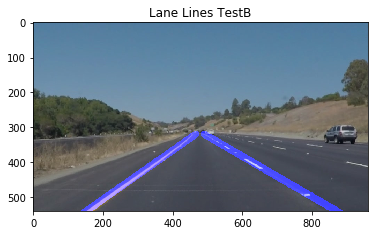

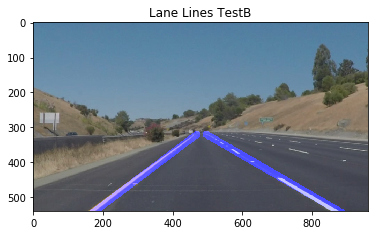

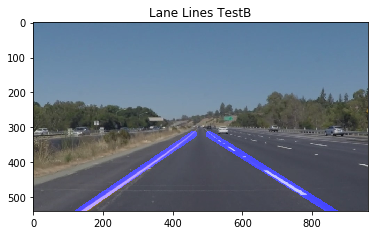

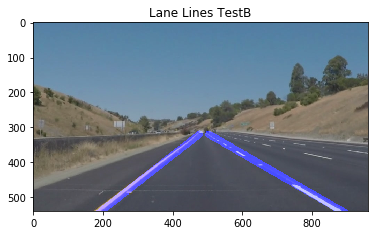

In [16]:
def hough_lines(img):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    draw_lines_avg(line_img, lines)
    return line_img


for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name)   
    wy = select_white_yellow(image)
    gray = grayscale(wy)
    smooth = gaussian_blur(gray)
    edged = canny(smooth)
    roi = region_of_interest(edged)
    lines = hough_lines(roi)
    annotated_img = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    plt.title('Lane Lines TestB')
    plt.imshow(annotated_img, cmap='gray')
    plt.show()
    

## Lane Finding Pipeline

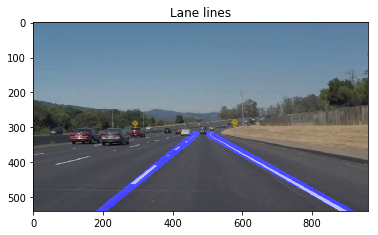

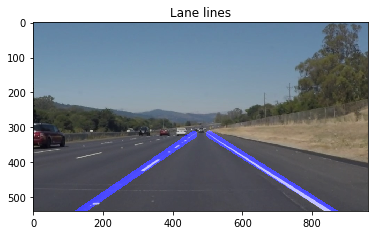

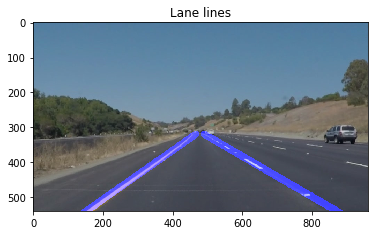

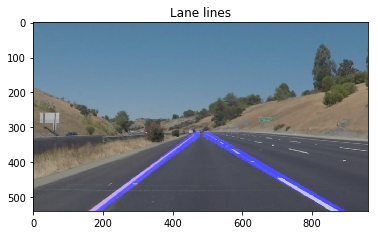

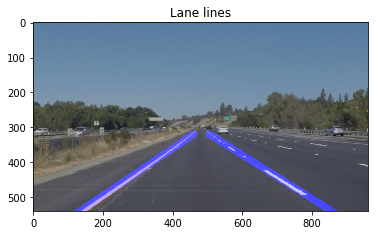

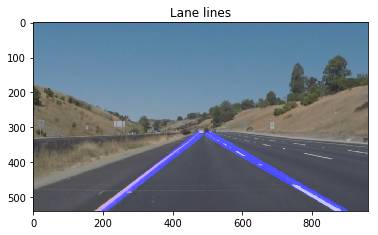

In [21]:
# Build the pipelines
#The folllowing function simplifies our pipeline
def annotate_lanes(image):   
    wy = select_white_yellow(image)
    gray = grayscale(wy)
    blur = gaussian_blur(gray)
    edged = canny(blur)
    roi = region_of_interest(edged)
    lines = hough_lines(roi)
    annotated_img = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return annotated_img
     
for file_name in file_names:
    # Read the image.
    image = mpimg.imread(in_dir + file_name)   
    annotated_img = annotate_lanes(image)
    plt.title('Lane lines')
    plt.imshow(annotated_img, cmap='gray')
    plt.show()
    plt.imsave(out_dir + file_name, annotated_img)

# Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

Let's try the one with the solid white lane on the right first ...

In [19]:
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(annotate_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:10<00:00, 21.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 11.6 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [26]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(annotate_lanes)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:31<00:00, 21.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 33.3 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

## Reflections¶

Congratulations on finding the lane lines! As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust? Where will your current algorithm be likely to fail?

Please add your thoughts below, and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

Attributions:
http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
http://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html
https://alyssaq.github.io/2014/understanding-hough-transform/

Shortcomings and Possible improvements

The lane finding pipeline built in this project only detects the straight lane lines. It is an advanced topic to detect the curvature of lanes. We'll need to use perspective transformation and also poly fitting lane lines rather than fitting to straight lines. Having said that, the lanes near the car are mostly straight in the images. The curvature appears at further distance unless it's a steep curve. So, this basic lane finding technique is still very useful.

Improvements can be done to take smaller line segments and integrate them to find curves instead of linear lines. Different luminosity factors can be considered to design the algorithm in a way that it works for brighter as well as darker lane lines irrespective of time of the day. 

Challenges may also be expected in regions where lane lines are not clear. For example, it will be challenging to detect lane lines on steep roads because the region of interest mask is assumed from the center of the image. For steep roads, we first need to detect the horizontal line so that we can determine where the lines should extend.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(annotate_lanes)
%time challenge_clip.write_videofile(challenge_output, audio=False)


In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
  
</video>
""".format(challenge_output))